In [15]:
# some visualization of coughing data

In [1]:
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# meta
# hard-coded thresholds for features
ap_thresholds = pd.read_csv("preprocessing_meta/AP_thresholds.csv", index_col=0)
mc_thresholds = pd.read_csv("preprocessing_meta/MC_thresholds.csv", index_col=0)

In [3]:
def get_airspeck(id):
    '''
    Preprocess and return a dataframe of airspeck measurements for a given ID.
    '''

    cohort = id[1:3]
    file = f"../data/DAPHNE/airspeck_{cohort}/{id}_airspeck_personal_manual.csv"
    airspeck = pd.read_csv(file, infer_datetime_format=True, parse_dates=["timestamp"], index_col=["timestamp"])
    # drop duplicate timestamps
    airspeck = airspeck.reset_index().drop_duplicates(subset=["timestamp"]).set_index("timestamp")
    # add missing observations
    airspeck = airspeck.resample("1T").mean()

    # features I care about
    features = ["pm2_5", "temperature", "humidity", 'gpsLongitude', 'gpsLatitude', 'gpsAltitude', 'gpsAccuracy']
    # percentiles used in smoothing - these are percentiles
    # of the distribution of the local standard deviation of 
    # each feature, used to identify any incorrect spikes in the data
    percentiles = ["99", "99", "90"]
    for feature, percentile in zip(features[:3], percentiles):
        # hard thresholds
        if cohort == "AP":
            lower, upper = ap_thresholds.loc[feature].values
        else:
            lower, upper = mc_thresholds.loc[feature].values
        airspeck[feature] = airspeck[feature].apply(lambda x: x if x > lower and x < upper else np.nan)  
        # also deal with infinite values
        airspeck[feature] = airspeck[feature].apply(lambda x: np.nan if x == np.inf else x)
        airspeck[feature] = airspeck[feature].apply(lambda x: np.nan if x == -np.inf else x)

        # smooth features by directly removing spikes    
        smoothing_thresholds = pd.read_csv(f"preprocessing_meta/smoothing_{cohort}/{feature}_std_quantiles.csv", index_col=0)
        cutoff = smoothing_thresholds.loc[5, percentile]
        airspeck["spikes"] = (airspeck.loc[:, feature].diff().abs() < cutoff).values
        # df.diff().abs(): absolute difference from the value of previous row
        airspeck[feature] = airspeck.apply(lambda row: row[feature] if row.spikes else np.nan, axis=1)
    return airspeck[features]

In [4]:
df = get_airspeck('DAP017(1)')

In [5]:
df

,pm2_5,temperature,humidity,gpsLongitude,gpsLatitude,gpsAltitude,gpsAccuracy
timestamp,,,,,,,
2018-11-22 08:35:00,NaN,NaN,NaN,77.238717,28.493969,88.500000,45.681875
2018-11-22 08:36:00,74.544219,40.800000,56.400000,77.238854,28.493988,226.000000,5.486857
2018-11-22 08:37:00,81.481004,NaN,NaN,77.238827,28.494000,219.625000,6.895000
2018-11-22 08:38:00,80.550220,NaN,NaN,77.238826,28.493981,219.000000,6.283875
2018-11-22 08:39:00,80.868932,NaN,51.414287,77.238821,28.493976,218.428571,6.278429
...,...,...,...,...,...,...,...
2018-11-24 08:31:00,122.809016,27.400000,42.200000,77.238857,28.493957,189.000000,15.500286
2018-11-24 08:32:00,119.406645,27.325001,42.575000,77.238857,28.493957,189.000000,18.625500
2018-11-24 08:33:00,119.958709,27.300001,42.914286,77.238857,28.493957,189.000000,25.133000


In [6]:
def view_missing_value(df):
    for column in list(df.columns):
        print("{}:  {} % missing values \n".format(column, ((len(df) - df[column].count()) / len(df))*100))

In [7]:
view_missing_value(df)

pm2_5:  33.946546338077056 % missing values 

temperature:  54.390836515098925 % missing values 

humidity:  60.222145088510935 % missing values 

gpsLongitude:  33.009371745921555 % missing values 

gpsLatitude:  33.009371745921555 % missing values 

gpsAltitude:  33.009371745921555 % missing values 

gpsAccuracy:  33.009371745921555 % missing values 



In [8]:
df_inter_full = df.interpolate().ffill().bfill()
view_missing_value(df_inter_full)

pm2_5:  0.0 % missing values 

temperature:  0.0 % missing values 

humidity:  0.0 % missing values 

gpsLongitude:  0.0 % missing values 

gpsLatitude:  0.0 % missing values 

gpsAltitude:  0.0 % missing values 

gpsAccuracy:  0.0 % missing values 



In [9]:
df_inter_15 = df.interpolate(method="linear", limit=15)
view_missing_value(df_inter_15)

pm2_5:  29.295383547379384 % missing values 

temperature:  50.50329746615758 % missing values 

humidity:  50.74626865671642 % missing values 

gpsLongitude:  29.017702186740713 % missing values 

gpsLatitude:  29.017702186740713 % missing values 

gpsAltitude:  29.017702186740713 % missing values 

gpsAccuracy:  29.017702186740713 % missing values 



In [10]:
from functools import reduce
import operator
def prod(factors):
    return reduce(operator.mul, factors, 1)

In [11]:
def get_coughing_origin(id):
    '''
    Return a dataframe of coughing measurements for a given ID.
    '''

    file = f"../data/DAPHNE/coughing/{id}.csv"
    coughing = pd.read_csv(file, infer_datetime_format=True, parse_dates=["timestamp"], index_col=["timestamp"])
    # drop duplicate timestamps
    coughing = coughing.reset_index().drop_duplicates(subset=["timestamp"]).set_index("timestamp")
    coughing = coughing.resample('1T').agg(lambda x: sum(x))
    
    return coughing

In [12]:
def get_coughing(id):
    '''
    Return a dataframe of coughing measurements for a given ID.
    '''

    file = f"../data/DAPHNE/coughing/{id}.csv"
    coughing = pd.read_csv(file, infer_datetime_format=True, parse_dates=["timestamp"], index_col=["timestamp"])
    # drop duplicate timestamps
    coughing = coughing.reset_index().drop_duplicates(subset=["timestamp"]).set_index("timestamp")
    coughing = coughing.resample('1T').agg(lambda x: 1-prod(1-x))
    
    return coughing

In [13]:
def plot_coughing(trial):
    fig, ax = plt.subplots(4, figsize=(16,16))
    cough = get_coughing(trial)
    # Split 48 hours in two 4 subplots of 12 hours
    for i, split in enumerate(np.array_split(cough, 4)):
        ax[i].plot(cough.index.values, cough, label =("Probability of coughing in 1 minute" if i == 0 else ""))
        ax[i].set_ylabel("Probability of coughing")
        ax[i].set_xlabel("Timestamp")
                 
        ax[i].set(xlim=(split.index[0], split.index[-1]))
    plt.subplots_adjust(hspace=0.5)
    fig.legend()
    
    fig.suptitle("{} coughing episodes over time".format(trial), fontsize=16)
    
    print("Saving file {}".format(trial))
    
    #plt.savefig("results/coughing_plots/{}_cough_vs_pm2_5.pdf".format(trial))
    plt.show()

Saving file DAP017(1)


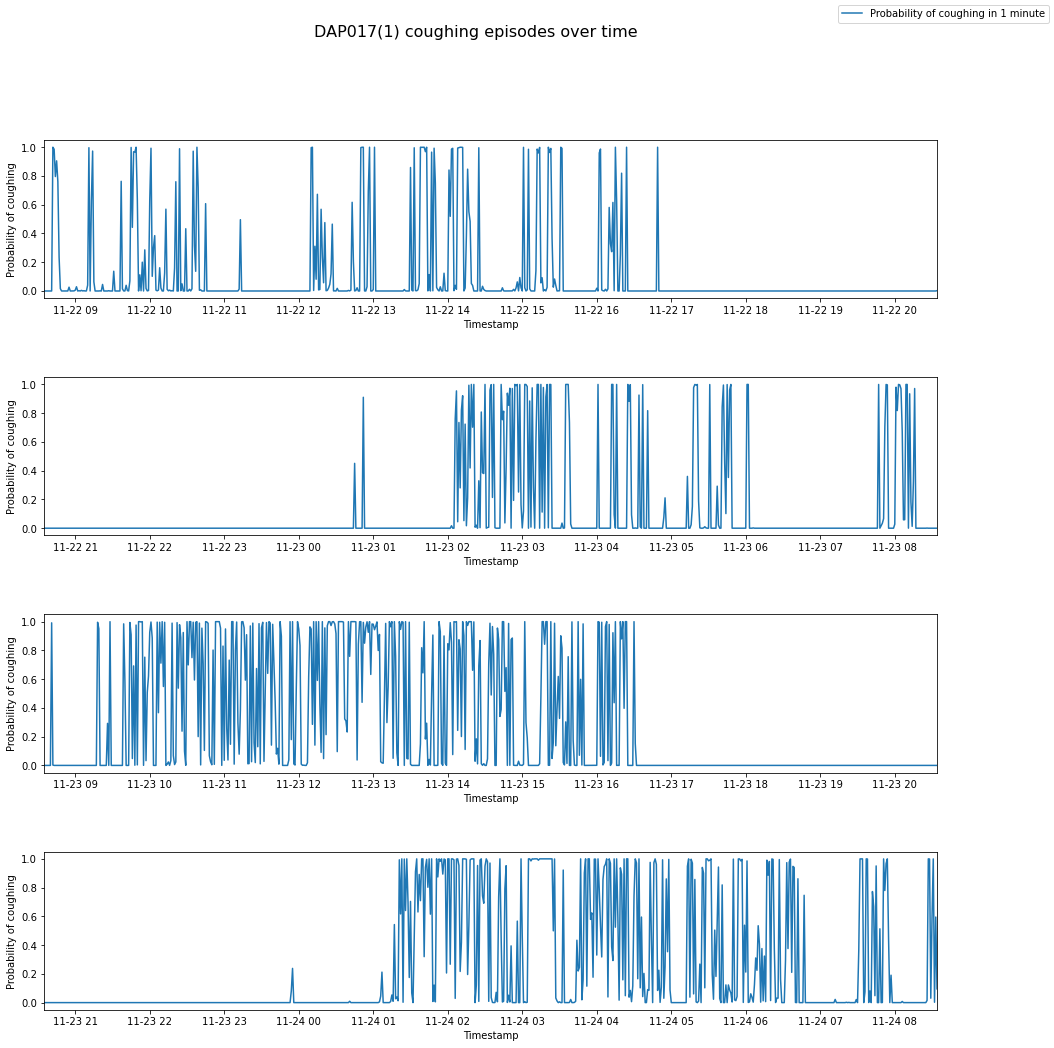

In [14]:
plot_coughing('DAP017(1)')

In [21]:
def plot_coughing_graph(trial):
    fig, ax = plt.subplots(4, figsize=(16, 16))
    
    # airspeck = get_airspeck(trial).interpolate().ffill().bfill()
    # Normalize
    # airspeck["pm2_5"] = MinMaxScaler().fit_transform(airspeck["pm2_5"].values.reshape(-1, 1))
    # cough = get_coughing(trial)
    # Split 48 hours in two 4 subplots of 12 hours
    airspeck = pd.read_csv(f"../data/DAPHNE/PCMCI/{trial}.csv",
                                  infer_datetime_format=True, parse_dates=["timestamp"], index_col="timestamp")
    cough = airspeck['coughing']
    
    for i, split in enumerate(np.array_split(airspeck, 4)):
        ax[i].plot(cough.index.values, cough, label =("# of coughing episodes" if i == 0 else ""))
        ax[i].set_ylabel("# of coughing episodes")
        ax[i].set_xlabel("Timestamp")
        
        ax2 = ax[i].twinx()
        ax2.set_ylabel("Normalized PM2.5")
        ax2.plot(split["pm2_5"], color='m', label=("PM2.5 concentration" if i == 0 else ""))
                 
        ax[i].set(xlim=(split.index[0], split.index[-1]))

    plt.subplots_adjust(hspace=0.5)
    fig.legend()
    
    fig.suptitle("{} PM2.5 concentration and coughing episodes over time with".format(trial), fontsize=16)
    
    print("Saving file {}".format(trial))
    
    plt.savefig("results/coughing_plots/{}_cough_vs_pm2_5.pdf".format(trial))
    plt.show()

Saving file DAP017(1)


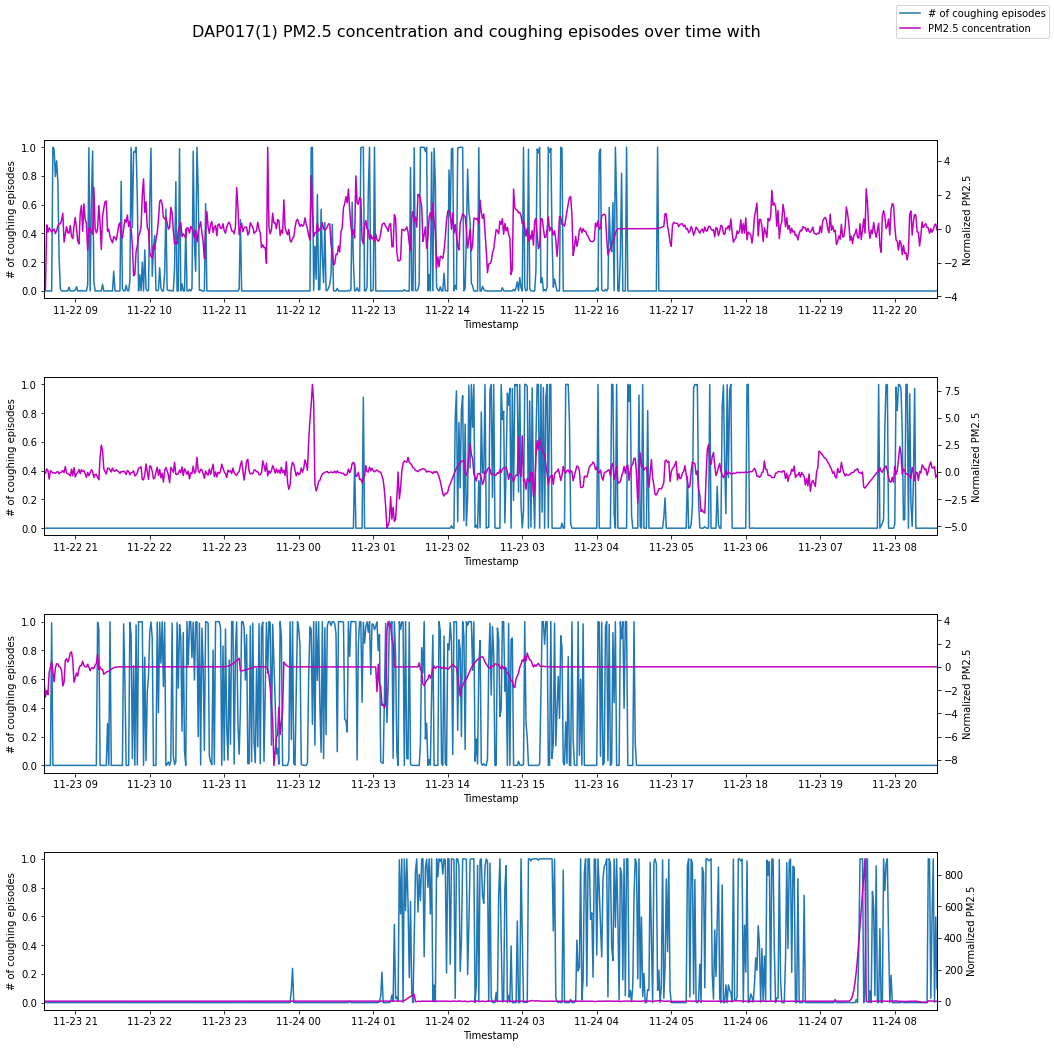

In [22]:
plot_coughing_graph('DAP017(1)')